# Equation Rendering

Equation Rendering notebook 

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import jellyfish

import tensorflow as tf
from tensorflow.keras.preprocessing.image import smart_resize


#default libaries
import glob
import sys
import os
import re
import string
from IPython.display import display, Latex
from importlib import reload 

#custom 
import resolve_symbols
import render_equations
import box_positions

In [118]:
reload(resolve_symbols) #debugging
reload(render_equations)
from resolve_symbols import resolve_symbols_on_img
from render_equations import render_equation
reload(box_positions)
from box_positions import BoxPositions


Load in class labels from class_names.txt 

In [5]:
with open('../class_names.txt', 'r') as f:
    lines = f.readlines()
class_labels = [label.split(' ')[-1][:-1] for label in lines]

Load in the model

In [111]:
efficientnet_model = tf.keras.models.load_model('../CNN_model/efficientnet_model.h5')
efficientnet_model_lw = tf.keras.models.load_model('../CNN_model/efficientnet_model_lw.h5')
efficientnet_model_lw2 = tf.keras.models.load_model('../CNN_model/efficientnet_model_lw2.h5')


Now let's write a function to actually make a prediction with the efficientnet model

In [80]:
def make_predictions(symbol_list, extend_list, model=efficientnet_model):

    pred_list = []
    pred_symbol_list, pred_idx_list = [], []
    for i, symbol in enumerate(symbol_list):

        rgb_im = np.zeros((symbol.shape[0], symbol.shape[1], 3))
        for j in range(3):
            rgb_im[:,:,j] = symbol.astype('uint8')
        resize_img = smart_resize(rgb_im, (100,100))
        resize_img = np.expand_dims(resize_img, axis=0)
        prediction = model.predict(resize_img, verbose=0)
    
        pred_dic = {k[6:]:v for v,k in sorted(zip(prediction[0], class_labels))[-4:]}
        y_classes = prediction.argmax(axis=-1)
        pred_idx_list.append(y_classes)
        label = class_labels[y_classes[0]][6:]
        
        #check if a symbol extends over multiple adjacent symbols
        #if it's not a square root, check if the square root is predicted at a lower probability
        #if so, just use that
        if extend_list[i] >  1 and label != '\\sqrt':
            if '\\sqrt' in pred_dic.keys(): 
                label = '\\sqrt'
        
            
        pred_symbol_list.append(label)
        pred_list.append(pred_dic)
    return pred_symbol_list

load in the images in order:

In [103]:
full_eq_imgs = []
eq_dir = '../img_data/full_equations/'
for i in range(1200):
    if os.path.isfile(eq_dir + 'full_eq_' + str(i) + '.png') == True:
        full_eq_imgs.append(eq_dir + 'full_eq_' + str(i) + '.png')

../img_data/full_equations/full_eq_10.png


Text(250, 400, '$ ( ( 3 1 ! 5 2 ) - ( 2 1 , 1 2 0 ) ) \\times 1 0 2 \\geq 4 2$')

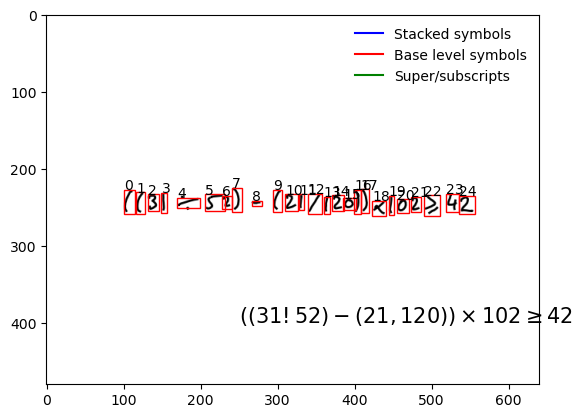

In [109]:
img_idx = 10
print(full_eq_imgs[10])
symbs, levels, stack, script_levels, extend_list, fig, ax = resolve_symbols_on_img(full_eq_imgs[img_idx])

pred_symbol_list = make_predictions(symbs, extend_list, model=efficientnet_model)
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)

ax.text(250, 400, r'' + eqstr, fontsize=15)

In [102]:
pred_symbol_list

['(',
 '(',
 '3',
 '1',
 '\\div',
 '5',
 '7',
 ')',
 '-',
 '(',
 '2',
 '1',
 '1',
 '1',
 'z',
 '0',
 '1',
 ')',
 'k',
 '1',
 '0',
 'q',
 '\\geq',
 '4',
 '2']

In [76]:
pred_symbol_list

['(',
 '(',
 '3',
 '1',
 '!',
 '5',
 '2',
 ')',
 '-',
 '(',
 '2',
 '1',
 ',',
 '1',
 '2',
 '0',
 ')',
 ')',
 '\\times',
 '1',
 '0',
 '2',
 '\\geq',
 '4',
 '2']

In [10]:
display(Latex(eqstr))

<IPython.core.display.Latex object>

### Evaluating the performance of the full pipeline

Now that the full pipeline is working, we want to know how well it does at actually predicting the equation label.
In order to gauge this, we will use the 'damerau-levenshtein distance', which measures how many symbols in two strings are different or need to be transposed

First let's retrieve the images we want to predict on

And load in the corresponding equation labels

In [11]:
#equation labels
with open(eq_dir + 'eq_labels.txt') as f:
    full_labels = f.readlines()
full_labels = [label[:-2].split(':: ')[1] for label in full_labels if 'eq' in label]

In [12]:
print(len(full_labels), len(full_eq_imgs))

1129 1129


In [13]:
for label in full_labels:
    if 'mbox' in label: print(label)

In [14]:
comp_l = ['\\sum', '\\lim']
lim_labels = [label for label in full_labels if comp_l[0] in label or comp_l[1] in label]
trig_l = ['\\cos', '\\tan', '\\sin']
trig_labels = [label for label in full_labels if (trig_l[0] in label or trig_l[1] in label or trig_l[2] in label) and label not in lim_labels]


In order to make sure my equation strings and the labels look as similar as possible, I 'reprocess' the equation labels. One example of why this is necessary is that in the equation labels, if a single symbol is in a super or subscript ('^' or '_'), the symbol will somtimes not have curly brackets around them. 

Additionally, when calculating the damerau-levenshtein distance, I really want to equate symbols with symbols - not pure string characters. For example, if my model predicts a 6, but the actual label is \\theta, the penalty would be that we got 6 characters wrong, while it should really just be one. That's why when comparing the actual distance, I use 'relabeled' equations, where each symbol, or curly bracket is relabeled with a single ascii character.

In [15]:
def reprocess_eq(input_eq):
    """
    Reprocess the equation label, so that the comparison with the predicted equation label can be made
    Because I'm using the demerau-levenshtein distance to compare the predicted and actual equation strings
    it's important that the two are formatted as similarly as possible
    Input:
        equation string, read in from eq_labels.txct
    Returns:
        reprocessed equation string
    """
    
    #remove all whitespace and math mode markings ($), and make sure brackets are always labeled the same way
    input_eq = input_eq.replace('$', '').replace('\\left(','(').replace('\\right)',')').replace('\\)',')').replace('\\(','(').replace('\\lt','<').replace('\\gt','>')
                                                                                                                            
    #add curly brackets around superscripts and subscriptt
    br_ct = 0
    idx_l = []
    
    #first count how many instances of ^ and _ NOT followed by a curly bracket there are
    ss_list = ['^', '_']
    for i,s in enumerate(input_eq[:-1]):
        if s in ss_list and input_eq[i+1] != '{':
            idx_l.append(i+1)
            br_ct += 1
        
    #then rewrite the string piece by piece, adding curly opening and closing brackets where necessary
    input_eq_n = ''
    p = 0
    at_end = False
    for i in range(br_ct):

        input_eq_n += input_eq[p:idx_l[i]] + '{' + input_eq[idx_l[i]] + '}'
        if idx_l[i] == len(input_eq) - 1:
            at_end = True
        if at_end == False:
            p = idx_l[i]+1
            
    if at_end == False:
        input_eq_n += input_eq[p:]
    return input_eq_n

In [48]:
def relabel_equations(input_eq1, input_eq2):
    """
    Given two equation strings, split them by several types of delimiters at the same time,
    then find the number of unique entries in the total of two lists, and then relabel each unique entry and put it back into string type
    This so I can calculate the demerau-levenshtein distance without eg \\theta counting for more than b or a 
    Returns:
        two new equation strings, where each single character is replaced by an ASCII character
    """
    #ascii symbols
    charlist = string.printable

    #split both equations according to a bunch of delimiters
    delimiters = ['{','}','^','_','-','\+','\(','\)','=','1','2','3','4','5','6','7','8','9','0',' ']
    del_str = '|'.join(delimiters)
    #wrapping the delimiter string in parenthesis to make sure the delimiters are kept in as well
    input_eq1_l = re.split('(' + del_str + ')', input_eq1)
    input_eq2_l = re.split('(' + del_str + ')', input_eq2)
    
    #remove whitespace entries 
    input_eq1_l = [i for i in input_eq1_l if i != '' and i!= ' ']
    input_eq2_l = [i for i in input_eq2_l if i != '' and i!= ' ']

    #find the set of unique symbols of the combined lists
    n_unique  = list(set(input_eq1_l + input_eq2_l))
    
    #turn into arrays for easier indexing
    input_eq1_l, input_eq2_l = np.array(input_eq1_l), np.array(input_eq2_l)
    
    for i,val in enumerate(list(n_unique)):
        if val in input_eq1_l:
            input_eq1_l[input_eq1_l == val] = charlist[i]
        if val in input_eq2_l:
            input_eq2_l[input_eq2_l == val] = charlist[i]
            
    relabeled_eq1 = ''.join(list(input_eq1_l))
    relabeled_eq2 = ''.join(list(input_eq2_l))

    return relabeled_eq1, relabeled_eq2

Now let's go through the full pipeline, and calculate the levenshtein-damerau distance between the predicted and actual equation strings

In [119]:
lvs_n, lvs_c, lvs_t = [],[],[]
lvs_a = []
for a in range(len(full_labels)):
    if a%100==0:print(a)
    
    symbs, levels, stack, script_levels, extend_list = resolve_symbols_on_img(full_eq_imgs[a], plot=False)
    pred_symbol_list = make_predictions(symbs, extend_list)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    
    #remove math mode $ to compare equations
    predicted_eq = eqstr.replace('$', '')
    
    #reprocess actual equation label so that formatting is consistent
    actual_eq = reprocess_eq(full_labels[a])
    
    #relabel equations with single ascii characters, so that if eg. my model predicts '6' instead of '\\theta', the string distance is not overly penalized
    pred_eq_relabeled, actual_eq_relabeled = relabel_equations(predicted_eq, actual_eq)
    
    dl_dist = jellyfish.damerau_levenshtein_distance(pred_eq_relabeled, actual_eq_relabeled)/len(actual_eq_relabeled)
    if full_labels[a] in lim_labels:
        lvs_c.append(dl_dist)
    elif full_labels[a] in trig_labels:
        lvs_t.append(dl_dist)
    else:
        lvs_n.append(dl_dist)
    lvs_a.append(dl_dist)

0
100
200
300
400
500
600
700
800
900
1000
1100


In [120]:
lvs_n2, lvs_c2, lvs_t2 = [],[],[]
lvs_a2 = []
for a in range(len(full_labels)):
    if a%100==0:print(a)
    
    symbs, levels, stack, script_levels, extend_list = resolve_symbols_on_img(full_eq_imgs[a], plot=False)
    pred_symbol_list = make_predictions(symbs, extend_list, model=efficientnet_model_lw)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    
    #remove math mode $ to compare equations
    predicted_eq = eqstr.replace('$', '')
    
    #reprocess actual equation label so that formatting is consistent
    actual_eq = reprocess_eq(full_labels[a])
    
    #relabel equations with single ascii characters, so that if eg. my model predicts '6' instead of '\\theta', the string distance is not overly penalized
    pred_eq_relabeled, actual_eq_relabeled = relabel_equations(predicted_eq, actual_eq)
    
    dl_dist = jellyfish.damerau_levenshtein_distance(pred_eq_relabeled, actual_eq_relabeled)/len(actual_eq_relabeled)
    if full_labels[a] in lim_labels:
        lvs_c2.append(dl_dist)
    elif full_labels[a] in trig_labels:
        lvs_t2.append(dl_dist)
    else:
        lvs_n2.append(dl_dist)
    lvs_a2.append(dl_dist)

0
100
200
300
400
500
600
700
800
900
1000
1100


In [121]:
lvs_n3, lvs_c3, lvs_t3 = [],[],[]
lvs_a3 = []
for a in range(len(full_labels)):
    if a%100==0:print(a)
    
    symbs, levels, stack, script_levels, extend_list = resolve_symbols_on_img(full_eq_imgs[a], plot=False)
    pred_symbol_list = make_predictions(symbs, extend_list, model=efficientnet_model_lw2)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    
    #remove math mode $ to compare equations
    predicted_eq = eqstr.replace('$', '')
    
    #reprocess actual equation label so that formatting is consistent
    actual_eq = reprocess_eq(full_labels[a])
    
    #relabel equations with single ascii characters, so that if eg. my model predicts '6' instead of '\\theta', the string distance is not overly penalized
    pred_eq_relabeled, actual_eq_relabeled = relabel_equations(predicted_eq, actual_eq)
    
    dl_dist = jellyfish.damerau_levenshtein_distance(pred_eq_relabeled, actual_eq_relabeled)/len(actual_eq_relabeled)
    if full_labels[a] in lim_labels:
        lvs_c3.append(dl_dist)
    elif full_labels[a] in trig_labels:
        lvs_t3.append(dl_dist)
    else:
        lvs_n3.append(dl_dist)
    lvs_a3.append(dl_dist)

0
100
200
300
400
500
600
700
800
900
1000
1100


In [122]:
lvs_a = np.array(lvs_a)
lvs_a2 = np.array(lvs_a2)
lvs_a3 = np.array(lvs_a2)

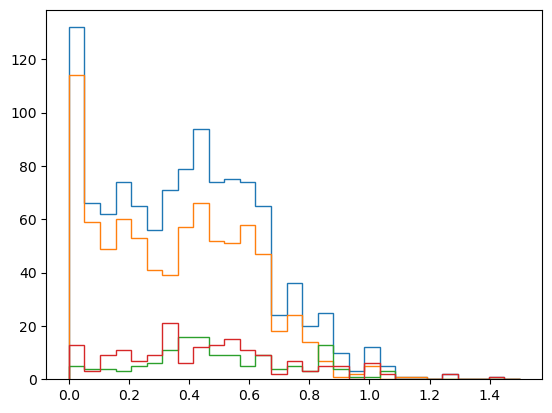

In [123]:
lbins = np.linspace(0, 1.5, 30)
plt.hist(lvs_a, bins=lbins, histtype='step')
plt.hist(lvs_n, bins=lbins, histtype='step')
plt.hist(lvs_c, bins=lbins, histtype='step')
plt.hist(lvs_t, bins=lbins, histtype='step')

plt.show()

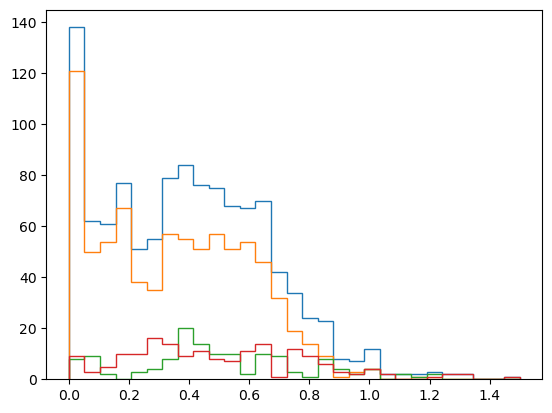

In [124]:
lbins = np.linspace(0, 1.5, 30)
plt.hist(lvs_a2, bins=lbins, histtype='step')
plt.hist(lvs_n2, bins=lbins, histtype='step')
plt.hist(lvs_c2, bins=lbins, histtype='step')
plt.hist(lvs_t2, bins=lbins, histtype='step')

plt.show()

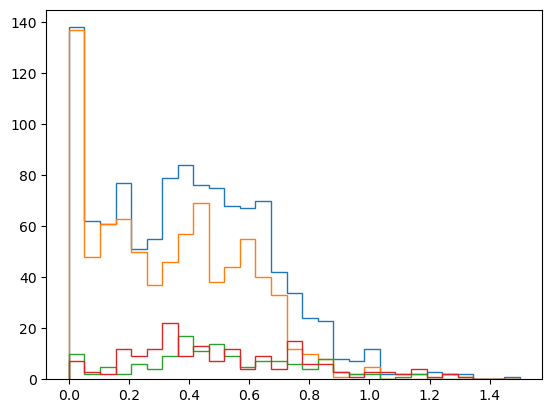

In [125]:
lbins = np.linspace(0, 1.5, 30)
plt.hist(lvs_a3, bins=lbins, histtype='step')
plt.hist(lvs_n3, bins=lbins, histtype='step')
plt.hist(lvs_c3, bins=lbins, histtype='step')
plt.hist(lvs_t3, bins=lbins, histtype='step')

plt.show()

In [126]:
def print_dist_info(input_dists):
    print('-' * 30)
    i_a = np.array(input_dists)
    p_0 = len(i_a[i_a == 0])/len(i_a)
    p_10 = len(i_a[i_a < 0.1])/len(i_a)
    p_25 = len(i_a[i_a < 0.25])/len(i_a)
    p_50 = len(i_a[i_a < 0.5])/len(i_a)

    print('perfect predictions:', p_0)
    print('normalized dist <0.1', p_10)   
    print('normalized dist <0.25', p_25)
    print('normalized dist <0.5', p_50)
    return

In [127]:
dists_l = [lvs_a3, lvs_n3, lvs_t3, lvs_c3]
for d in dists_l:
    print_dist_info(d)

------------------------------
perfect predictions: 0.11514614703277236
normalized dist <0.1 0.16209034543844109
normalized dist <0.25 0.3312666076173605
normalized dist <0.5 0.6350752878653676
------------------------------
perfect predictions: 0.15609756097560976
normalized dist <0.1 0.2121951219512195
normalized dist <0.25 0.424390243902439
normalized dist <0.5 0.7097560975609756
------------------------------
perfect predictions: 0.04046242774566474
normalized dist <0.1 0.057803468208092484
normalized dist <0.25 0.15028901734104047
normalized dist <0.5 0.5317919075144508
------------------------------
perfect predictions: 0.058823529411764705
normalized dist <0.1 0.08823529411764706
normalized dist <0.25 0.18382352941176472
normalized dist <0.5 0.49264705882352944


In [128]:
dists_l = [lvs_a2, lvs_n2, lvs_t2, lvs_c2]
for d in dists_l:
    print_dist_info(d)

------------------------------
perfect predictions: 0.11514614703277236
normalized dist <0.1 0.16209034543844109
normalized dist <0.25 0.3312666076173605
normalized dist <0.5 0.6350752878653676
------------------------------
perfect predictions: 0.1402439024390244
normalized dist <0.1 0.1902439024390244
normalized dist <0.25 0.3926829268292683
normalized dist <0.5 0.676829268292683
------------------------------
perfect predictions: 0.05202312138728324
normalized dist <0.1 0.06936416184971098
normalized dist <0.25 0.17341040462427745
normalized dist <0.5 0.5202312138728323
------------------------------
perfect predictions: 0.04411764705882353
normalized dist <0.1 0.11029411764705882
normalized dist <0.25 0.16176470588235295
normalized dist <0.5 0.5294117647058824


In [129]:
#1) all equations, 2) 'simple' equations, 3) equations with a trig function, 4) equations with a limit or sum sign
dists_l = [lvs_a, lvs_n, lvs_t, lvs_c]
for d in dists_l:
    print_dist_info(d)

------------------------------
perfect predictions: 0.10894596988485385
normalized dist <0.1 0.15411868910540302
normalized dist <0.25 0.3383525243578388
normalized dist <0.5 0.6483613817537643
------------------------------
perfect predictions: 0.12804878048780488
normalized dist <0.1 0.18414634146341463
normalized dist <0.25 0.3951219512195122
normalized dist <0.5 0.6914634146341463
------------------------------
perfect predictions: 0.07514450867052024
normalized dist <0.1 0.09248554913294797
normalized dist <0.25 0.21965317919075145
normalized dist <0.5 0.5491329479768786
------------------------------
perfect predictions: 0.03676470588235294
normalized dist <0.1 0.051470588235294115
normalized dist <0.25 0.14705882352941177
normalized dist <0.5 0.5147058823529411


In [63]:
idxs = np.where(lvs_a > 0.5)[0]

------------------------------
IDX: 220
ACTUAL EQ:  (72 \div 151) \div (10 \times 152) \leq 0
PREDICTED EQ:  \prime 7 2_{ \div} 1 5 1 ) \frac{ 0}{ d} 1 1 0 x 1 x ) \leq 0
DISTANCE: 0.6842105263157895
------------------------------
IDX: 225
ACTUAL EQ:  \frac{\tan \alpha - \tan \beta}{1 + \tan \alpha \tan \beta}
PREDICTED EQ:  \frac{ \tan \alpha - \sum_{ \cos z}{ , + t \cos \alpha k \infty \beta}}
DISTANCE: 0.6875
------------------------------
IDX: 237
ACTUAL EQ:  x^{i + 2 j \times k^{3} - 2 \frac{j}{i}}
PREDICTED EQ:  x^{ 1  +  2  )  x  t  <^{ 3 } -  2} \frac{ j^{ 1}}{ 1}
DISTANCE: 0.5714285714285714
------------------------------
IDX: 239
ACTUAL EQ:  \log_{2} 8 + \log_{3} 9 + \log_{4} 1 6
PREDICTED EQ:  b_{ g  a} 8 + l_{ g  1} S + t \theta g 4^{ 1  b}
DISTANCE: 0.6190476190476191
------------------------------
IDX: 243
ACTUAL EQ:  \frac{\sin B + \sin C}{\cos B + \cos C}
PREDICTED EQ:  \frac{ \sin B + a_{ 1  n  c}}{ c 0 5 \theta + \cos c}
DISTANCE: 0.6666666666666666


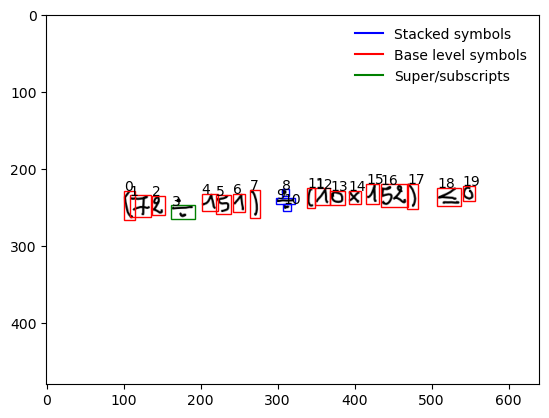

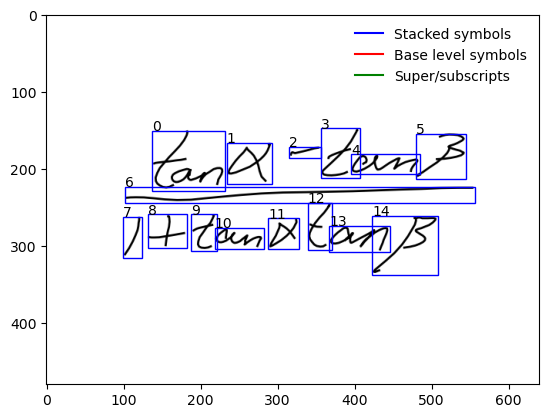

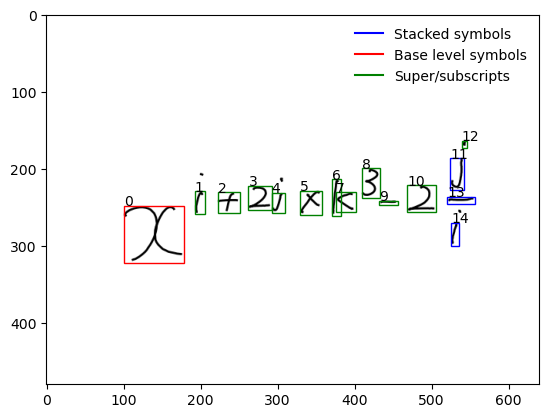

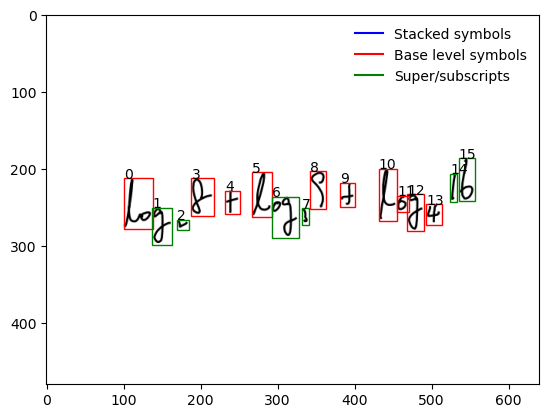

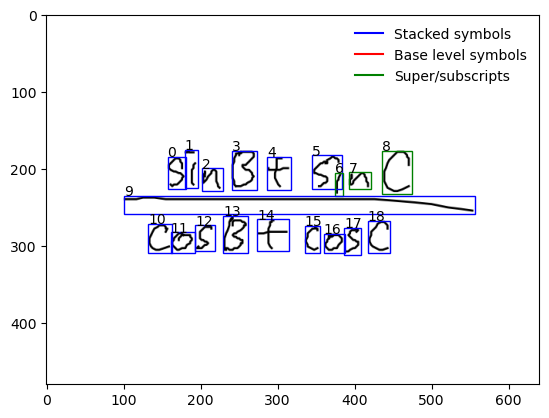

In [67]:
for a in idxs[40:45]:
    symbs, levels, stack, script_levels, extend_list, fig, ax  = resolve_symbols_on_img(full_eq_imgs[a], plot=True)
    pred_symbol_list = make_predictions(symbs, extend_list)
    eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
    
    actual_eq = reprocess_eq(full_labels[a])

    #remove math mode $ to compare equations
    predicted_eq = eqstr.replace('$', '')
    
    #reprocess actual equation label so that formatting is consistent
    actual_eq = reprocess_eq(full_labels[a])
    
    #relabel equations with single ascii characters, so that if eg. my model predicts '6' instead of '\\theta', the string distance is not overly penalized
    pred_eq_relabeled, actual_eq_relabeled = relabel_equations(predicted_eq, actual_eq)
    
    dl_dist = jellyfish.damerau_levenshtein_distance(pred_eq_relabeled, actual_eq_relabeled)/len(actual_eq_relabeled)
    print('-' *30)
    print('IDX:', a)
    print('ACTUAL EQ:', actual_eq)
    print('PREDICTED EQ:', predicted_eq)
    print('DISTANCE:', dl_dist)

In [476]:
pred_symbol_list

['x',
 '1',
 '-',
 'x',
 '2',
 '+',
 'y',
 '(',
 '-',
 'y',
 '3',
 '+',
 'z',
 '1',
 '-',
 'z',
 '2']

In [317]:
print(pred_symbol_list)

['\\gamma', '(', 'capital_X', ')', '=', '\\tan', 'n', '\\rightarrow', '\\infty', 'n', '!', 'n', 'k', '-', '\\times', '(', 'n', '+', '1', 'y']


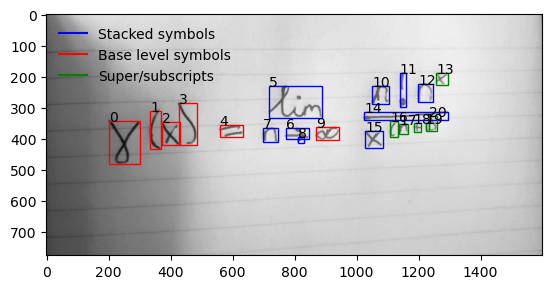

In [444]:
symbs, levels, stack, script_levels, extend_list, fig, ax  = resolve_symbols_on_img('../math_martijn.jpeg', plot=True)
pred_symbol_list = make_predictions(symbs, extend_list)


In [445]:
eqstr = render_equation(pred_symbol_list, levels, stack, script_levels, extend_list)
display(Latex(eqstr))


<IPython.core.display.Latex object>

In [332]:
img_file = '../img_data/train_symbols/label_\\lim/img_3.png'
img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)

make_predictions([img], [0])
#symb = o
#for symb in symbs[3:6]:
#    plt.figure()
#    plt.imshow(symb, cmap='gray')

0


['\\lim']

In [355]:
pred_symbol_list

['8',
 '(',
 'capital_X',
 ')',
 '=',
 '\\lim',
 '\\rightarrow',
 'n',
 '1',
 '\\infty',
 'n',
 '!',
 'n',
 'k',
 '-',
 'x',
 '(',
 'n',
 '+',
 '1',
 '\\lambda']

(array([3.95000e+02, 1.12400e+03, 1.80900e+03, 1.59000e+03, 1.83700e+03,
        1.97700e+03, 2.01900e+03, 1.75300e+03, 1.78400e+03, 1.75000e+03,
        2.59000e+03, 3.43700e+03, 4.85600e+03, 6.11500e+03, 7.25200e+03,
        8.85300e+03, 9.17200e+03, 1.08380e+04, 1.23290e+04, 1.77560e+04,
        1.94500e+04, 2.60030e+04, 3.23980e+04, 4.90790e+04, 6.18470e+04,
        8.56900e+04, 9.75960e+04, 1.40878e+05, 1.79397e+05, 6.48426e+05]),
 array([  1.        ,   9.46666667,  17.93333333,  26.4       ,
         34.86666667,  43.33333333,  51.8       ,  60.26666667,
         68.73333333,  77.2       ,  85.66666667,  94.13333333,
        102.6       , 111.06666667, 119.53333333, 128.        ,
        136.46666667, 144.93333333, 153.4       , 161.86666667,
        170.33333333, 178.8       , 187.26666667, 195.73333333,
        204.2       , 212.66666667, 221.13333333, 229.6       ,
        238.06666667, 246.53333333, 255.        ]),
 <BarContainer object of 30 artists>)

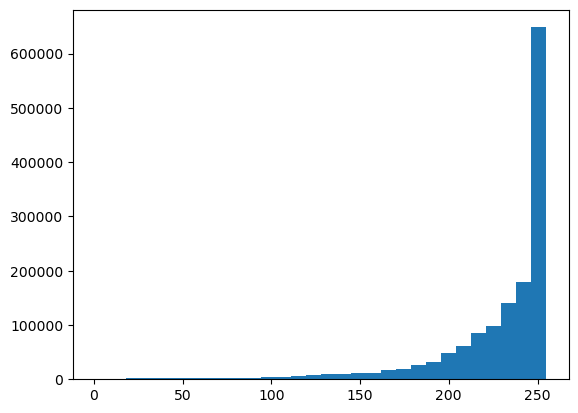

In [238]:
plt.hist(np.ravel(blur), bins=30)

In [383]:
'''
data = [
  [4.9, 3.1, 1.5, 0.1],
  [5.0, 3.2, 1.2, 0.2],
  [5.5, -3.5, 1.3, 0.2],
  [4.9, 3.1, -1.5, 0.1],
  [4.4, 3.0, 1.3, 0.2],
  [5.1, -1, 1.5, 0.2],
  [5.0, 3.5, -1.3, 0.3],
]
# 1. Write a method that returns true if the input dataset has any negative values.
# 2. Write a method to find the most frequent value of the 2nd column in the dataset.
# 3. Write a method that returns all rows of dataset that do not have any negative values.
'''

data = [
  [4.9, 3.1, 1.5, 0.1],
  [5.0, 3.2, 1.2, 0.2],
  [5.5, -3.5, 1.3, 0.2],
  [4.9, 3.1, -1.5, 0.1],
  [4.4, 3.0, 1.3, 0.2],
  [5.1, -1, 1.5, 0.2],
  [5.0, 3.5, -1.3, 0.3],
]



In [394]:
def hasNegative(input_data):
    
    neg_vals = sum([sum([0 if x >= 0 else 1 for x in row]) for row in input_data])
    if neg_vals > 0:
        return True
    else:
        return False

In [395]:
hasNegative(data)

True

In [418]:
def find_mode(input_data):
    col2 = [col[1] for col in input_data]
    mode_dic = {}
    for value in col2:
        if value in mode_dic.keys():
            mode_dic[value] +=1
        else:
            mode_dic[value] = 1
    return max(mode_dic, key=lambda key: mode_dic[key])

In [421]:
md = find_mode(data)

In [429]:
def getPositiveRows(input_data):
    neg_vals = [[0 if x >= 0 else 1 for x in row] for row in input_data]
    return [row for i,row in enumerate(input_data) if sum(neg_vals[i]) == 0]

In [430]:
getPositiveRows(data)

[[4.9, 3.1, 1.5, 0.1], [5.0, 3.2, 1.2, 0.2], [4.4, 3.0, 1.3, 0.2]]

In [226]:
import box_positions
reload(box_positions)
from box_positions import BoxPositions


In [227]:

box_pos1 = BoxPositions([424, 139, 513, 330],[442, 139, 557, 155])
box_pos2 = BoxPositions([442, 139, 557, 155], [424, 139, 513, 330])


In [228]:
box_pos1.calc_Overlap(axis='x', relative_to='smaller')

False False


0.797752808988764

In [229]:
box_pos2.calc_Overlap(axis='x', relative_to='smaller')

True True


0.797752808988764

In [230]:
box_pos1.calc_Overlap(axis='y', relative_to='both')
box_pos2.calc_Overlap(axis='y', relative_to='both')

False False
True True


1

In [231]:
box_pos1.y2s

[330, 155]

In [232]:
box_pos2.y2s

[155, 330]

In [200]:
box_pos1.y1s, box_pos1.

SyntaxError: invalid syntax (1829931305.py, line 1)